In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Data Preprocessing

In [3]:
# Load the dataset
file_path = 'AirQualityUCI _ Students.xlsx'
df = pd.read_excel(file_path)

# There is a 'Date' and 'Time' column:
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))


df = df.drop(columns=['Date', 'Time', 'NMHC(GT)'])

# Set DateTime as index, facilitate plot
df.set_index('DateTime', inplace=True)

# Sort data by DateTime
df.sort_values(by='DateTime', inplace=True)

# Generate a complete range of dates and times and frequency
full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

# Reindex the DataFrame to include all dates and times, filling missing ones with NaN
df = df.reindex(full_time_range)  # align with the full_time_range, adding missing timestamps

##### Handle the missing data
###### Though plot the data first, the chart shows periodic by 7 days. Therefore, fill the missing data with the data 7 days later.

In [4]:
# Replace missing values (-200) with NaN
df.replace(-200, pd.NA, inplace=True)

# Fill missing values with data 7 days after recursively
for i in range(2):
    #  According to the plot, CO(GT) shows  periodic with 7 days of period.
    #  Therefore, replace missing data with 7 days after, if still missing, 14 days after.
    df = df.combine_first(df.shift(-7*24*(i+1)))

# print('***', df['CO(GT)'].loc['2004-03-18'])

# Ensure there are no remaining NA values by forward and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

Show the plot of CO(GT) and NOx(GT)

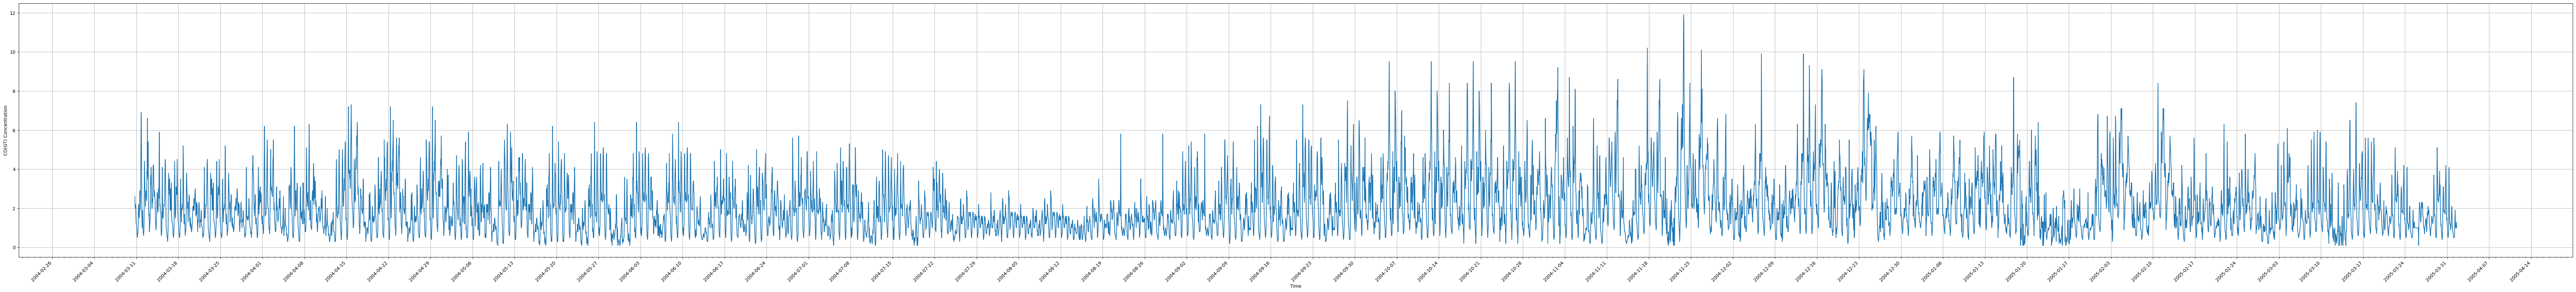

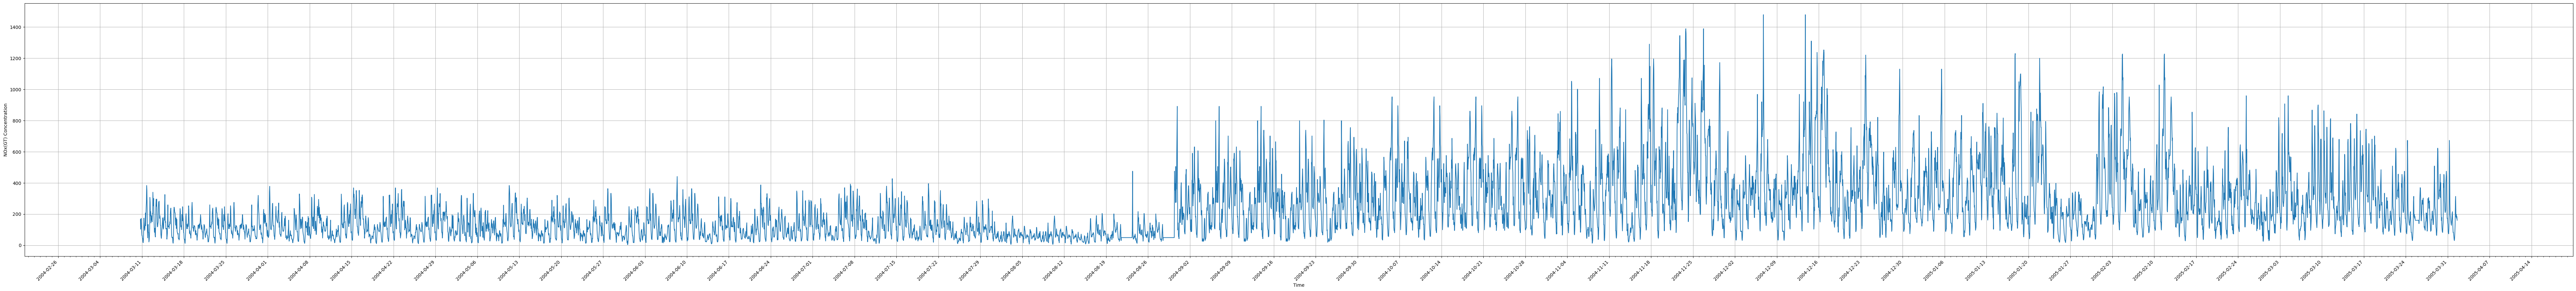

In [5]:
import matplotlib.dates as mdates

# plot CO(GT)
plt.figure(figsize=(100, 10))
plt.plot(df['CO(GT)'])
plt.xlabel('Time')
plt.ylabel('CO(GT) Concentration')

# Set major and minor ticks format for filtered_data plot
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Major ticks every 7 days
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Minor ticks every 12 hours
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.grid()
plt.show()

# plot NOx(GT)
plt.figure(figsize=(100, 10))
plt.plot(df['NOx(GT)'])
plt.xlabel('Time')
plt.ylabel('NOx(GT) Concentration')

# Set major and minor ticks format for filtered_data plot
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Major ticks every 7 days
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Minor ticks every 1 day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.grid()
plt.show()

As can be seen, the data shows periodic by 7 days. Therefore, fill the missing data with the data 7 days later.

# Task 1

Prepare data for training and testing

In [15]:
# Separate the input features and the target variable
features = df.drop(columns=['CO(GT)'])  # <class 'pandas.core.frame.DataFrame'>
target = df['CO(GT)']

# Normalize the input features with mean of 0 and unit deviation
scaler = StandardScaler()
features_pre = scaler.fit_transform(features)  # <class 'numpy.ndarray'>
# features_pre = features.values  # without standardization

# Create labels based on CO(GT) threshold
threshold = target.mean()
labels = (target > threshold).astype(int)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_pre, labels, test_size=0.2, random_state=42)
# Convert target variables to NumPy arrays
y_train = y_train.values
y_test = y_test.values

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


Design and train the neural network

In [7]:
# Initialize the neural network with a linear stack of layers
model1 = Sequential()

# dense layer: full-connected, 64 neurons
print("dimension of input: ", X_train.shape[1])  # 12
print("number of training samples: ", X_train.shape[0])  # 7428

# number of parameters: weights: 12*16+16*8 + 16 +  < 7428/10

# Create neural network
## Given that relu facilitate the process of derivation, I choose relu as activation function here
## To avoid overfitting, design less nerouns relatively.
model1.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dropout(0.5))  # dropout rates, alleviate overfitting
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.5))
## Choose sigmoid to do the binary classification
model1.add(Dense(1, activation='sigmoid'))

# binary_crossentropy is the loss function used for binary classification problems. 
# It measures the performance of a classification model whose output is a probability value between 0 and 1.
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # track the accuracy

# Train the model
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)  # verbose: print mode
# Make predictions
y_pred = model1.predict(X_test)
# print(X_test)
y_pred = (y_pred > 0.5).astype("int32")

dimension of input:  11
number of training samples:  7428
59/59 [==============================] - 0s 587us/step


Show the outcome

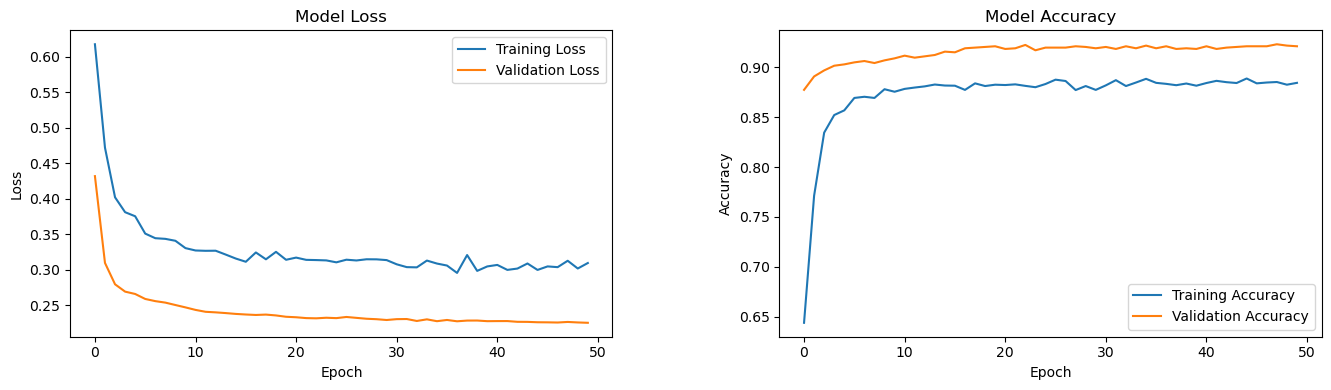

Confusion Matrix:
[[998  80]
 [ 82 697]]
Accuracy: 91.28%
Precision: 89.70%


In [8]:
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='lower right')

fig.subplots_adjust(wspace=20)

plt.tight_layout()
plt.show()

# print(y_test)
# Confusion Matrix, Accuracy, and Precision
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# print(type(y_test), y_test.shape, type(y_pred), y_pred.shape)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")

# Task 2

Prepare data for training and testing

In [9]:
# Separate the input features and the target variable
features = df.drop(columns=['NOx(GT)'])
target = df['NOx(GT)']

# Normalize the input features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)  # -> np.ndarray

# Convert target variables to NumPy arrays
y_train = y_train.values
y_test = y_test.values
# print(y_test.shape)

Design and train the neural network

In [10]:
# Design the neural network
model2 = Sequential()
model2.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
print(X_train.dtype, y_train.dtype, sep=',')
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions
y_pred = model2.predict(X_test)


float64,float64
59/59 [==============================] - 0s 536us/step


Show the outcome

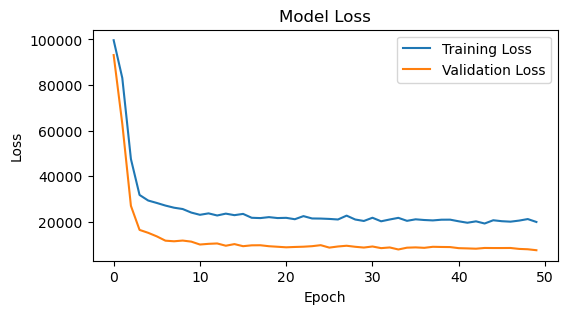

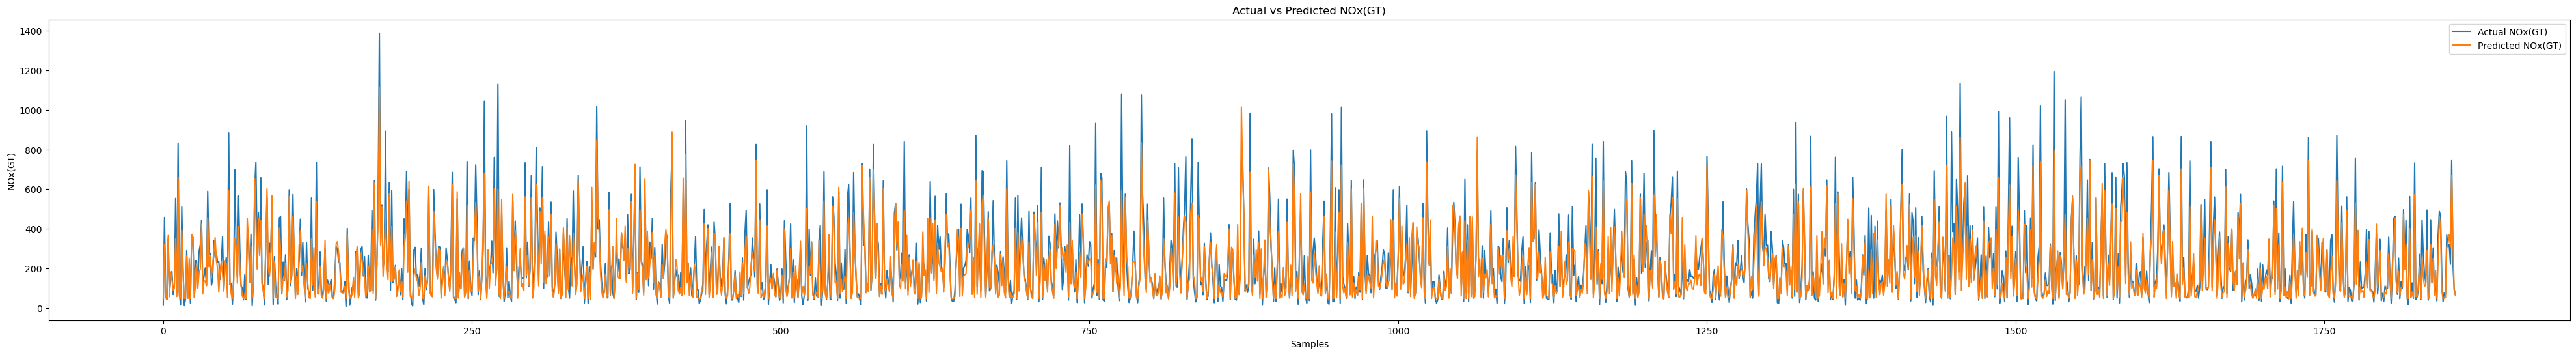

<class 'numpy.ndarray'> (1857,) <class 'numpy.ndarray'> (1857, 1)
[[ 47.20584 ]
 [319.74625 ]
 [ 49.316452]
 ...
 [358.87088 ]
 [ 89.525406]
 [ 64.993996]]
Root Mean Squared Error (RMSE): 84.32286278140207
Mean Absolute Error (MAE): 53.1046482462105


In [11]:
# Plot training and validation loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot predicted vs. actual values
plt.figure(figsize=(50, 6))
plt.plot(y_test, label='Actual NOx(GT)')
plt.plot(y_pred, label='Predicted NOx(GT)')
plt.title('Actual vs Predicted NOx(GT)')
plt.xlabel('Samples')
plt.ylabel('NOx(GT)')
plt.legend(loc='upper right')
plt.show()

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(type(y_test), y_test.shape, type(y_pred), y_pred.shape)
print(y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Test

Prepare dataset

In [12]:
# Load the dataset
file_path = 'Generalization Dataset.xlsx'
df = pd.read_excel(file_path)

df = df.drop(columns=['Date', 'Time', 'NMHC(GT)'])

df.replace(-200, pd.NA, inplace=True)
# print(df.isna().any().any())  # False

Test1

In [13]:
# Separate the input features and the target variable
x_test = df.drop(columns=['CO(GT)'])  # <class 'pandas.core.frame.DataFrame'>

# Normalize the input features with mean of 0 and unit deviation
scaler = StandardScaler()
x_pre = scaler.fit_transform(x_test)  # <class 'numpy.ndarray'>
# x_pre = x_test

threshold = df['CO(GT)'].mean()

y_pred = model1.predict(x_pre)
# print(x_scaled)
# print(y_pred)
y_pred = (y_pred > 0.5).astype("int32")

y_test = df['CO(GT)'].values
y_test = (y_test > threshold).astype("int32")

# print(type(y_pred), y_pred.dtype, type(y_test), y_test.dtype)

# print(y_test.shape, y_pred.shape)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")

28/28 [==============================] - 0s 577us/step
Confusion Matrix:
[[502  28]
 [ 25 317]]
Accuracy: 93.92%
Precision: 91.88%


Test2

In [14]:
x_test = df.drop(columns=['NOx(GT)'])  # <class 'pandas.core.frame.DataFrame'>

# Normalize the input features with mean of 0 and unit deviation
scaler = StandardScaler()
x_pre = scaler.fit_transform(x_test)  # <class 'numpy.ndarray'>
# x_pre = x_test

y_pred = model2.predict(x_pre)  # numpy.ndarray
y_test = df['NOx(GT)'].values

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# print(type(y_test), y_test.shape, type(y_pred), y_pred.shape)
# print(y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

28/28 [==============================] - 0s 577us/step
Root Mean Squared Error (RMSE): 96.98706008214475
Mean Absolute Error (MAE): 66.230681577735
